In [9]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)



2023.03.3


In [10]:
from rdkit.Chem.Descriptors import CalcMolDescriptors
def get_rdkit_descriptors(smile):
    return list(CalcMolDescriptors(Chem.MolFromSmiles(smile)).values())

In [13]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
SELECT cs_mdfps_schema.confid_data.conf_id AS confid,
       public.conformers.molblock,
       cs_mdfps_schema.experimental_data.vp
FROM cs_mdfps_schema.confid_data
INNER JOIN public.conformers
ON cs_mdfps_schema.confid_data.conf_id = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.experimental_data
ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835';

'''
# Execute the SQL query
cur.execute(sql_query)
results = cur.fetchall()
#print columns with index
print('Columns:')
for col in cur.description:
    print(col)
molblocks = [r[1] for r in results]
mols = [Chem.MolFromMolBlock(m) for m in molblocks]
mols = [Chem.AddHs(m) for m in mols]
MolDescriptors_vectors = [list(CalcMolDescriptors(m).values()) for m in mols]


Columns:
Column(name='confid', type_code=23)
Column(name='molblock', type_code=25)
Column(name='vp', type_code=701)


[12:52:28] Warning: molecule is tagged as 3D, but all Z coords are zero


In [14]:
#make df with each descriptor as a column and one column for the vp
vps = [r[2] for r in results]
confids = [r[0] for r in results]
df = pd.DataFrame(MolDescriptors_vectors, columns = list(CalcMolDescriptors(mols[0]).keys()))
df['vp'] = vps

In [15]:
#get the last column
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [16]:
# use feature importance for feature selection, with fix for xgboost 1.0.2
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = r2_score(y_test, predictions)
print("r2_score: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = model.get_booster().get_score(importance_type='weight')

feature_importance_dict = {k: v for k, v in sorted(thresholds.items(), key=lambda item: item[1], reverse=True)}


XGBoostError: [12:52:50] /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/data/data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(+0xb6361) [0x7fb3512b6361]
  [bt] (1) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(unsigned long xgboost::SparsePage::Push<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, float, int)+0x5d3) [0x7fb3513b6dd3]
  [bt] (2) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(xgboost::data::SimpleDMatrix::SimpleDMatrix<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int)+0x321) [0x7fb351411d61]
  [bt] (3) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(xgboost::DMatrix* xgboost::DMatrix::Create<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)+0x37) [0x7fb351396807]
  [bt] (4) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(XGDMatrixCreateFromDense+0x314) [0x7fb3512de564]
  [bt] (5) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7fb41220da4a]
  [bt] (6) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/../../libffi.so.8(+0x5fea) [0x7fb41220cfea]
  [bt] (7) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x12529) [0x7fb412225529]
  [bt] (8) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x8862) [0x7fb41221b862]



In [ ]:
feature_importance_dict

{'MaxAbsEStateIndex': 398.0,
 'MinAbsEStateIndex': 196.0,
 'qed': 145.0,
 'BCUT2D_CHGHI': 96.0,
 'MinPartialCharge': 86.0,
 'MaxPartialCharge': 79.0,
 'MinEStateIndex': 77.0,
 'FpDensityMorgan1': 72.0,
 'BCUT2D_MRLOW': 68.0,
 'BCUT2D_MWLOW': 67.0,
 'BalabanJ': 62.0,
 'BCUT2D_MWHI': 60.0,
 'BCUT2D_LOGPHI': 58.0,
 'Kappa3': 58.0,
 'BCUT2D_LOGPLOW': 57.0,
 'MolWt': 56.0,
 'BCUT2D_CHGLO': 56.0,
 'PEOE_VSA6': 55.0,
 'FpDensityMorgan3': 54.0,
 'FpDensityMorgan2': 52.0,
 'PEOE_VSA7': 52.0,
 'VSA_EState3': 50.0,
 'PEOE_VSA8': 48.0,
 'BertzCT': 47.0,
 'MinAbsPartialCharge': 46.0,
 'BCUT2D_MRHI': 46.0,
 'VSA_EState8': 45.0,
 'AvgIpc': 43.0,
 'EState_VSA3': 42.0,
 'TPSA': 41.0,
 'VSA_EState7': 40.0,
 'EState_VSA6': 36.0,
 'VSA_EState4': 36.0,
 'VSA_EState5': 35.0,
 'Chi3v': 33.0,
 'PEOE_VSA9': 32.0,
 'EState_VSA5': 32.0,
 'MolLogP': 32.0,
 'Kappa2': 30.0,
 'Chi2n': 29.0,
 'SMR_VSA5': 29.0,
 'MaxAbsPartialCharge': 28.0,
 'HeavyAtomMolWt': 27.0,
 'SMR_VSA10': 27.0,
 'VSA_EState2': 27.0,
 'Chi1v': 2

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score
treshs,ns,r2s = [],[],[]
treshs_list = list(set(feature_importance_dict.values()))
#sort, biggest first
treshs_list.sort(reverse=True)
for thresh in treshs_list:
    # Get features from feature_importance_dict with a value above the threshold
    new_features = [i for i in feature_importance_dict.keys() if feature_importance_dict[i] > thresh]

    # Check if there are selected features
    if len(new_features) == 0:
        print("No features selected for threshold %.3f" % thresh)
        continue

    # Now get DataFrames X with only the new features
    X_train_new = X_train[new_features]
    X_test_new = X_test[new_features]

    selection_model = xgb.XGBRegressor()
    selection_model.fit(X_train_new, y_train)
    
    # Evaluate the model
    predictions = selection_model.predict(X_test_new)
    accuracy = r2_score(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, r2_score: %.2f%%" % (thresh, X_train_new.shape[1], accuracy))
    treshs.append(thresh)
    ns.append(X_train_new.shape[1])
    r2s.append(accuracy)



No features selected for threshold 398.000
Thresh=196.000, n=1, r2_score: 0.19%
Thresh=145.000, n=2, r2_score: 0.35%
Thresh=96.000, n=3, r2_score: 0.51%
Thresh=86.000, n=4, r2_score: 0.56%
Thresh=79.000, n=5, r2_score: 0.64%
Thresh=77.000, n=6, r2_score: 0.68%
Thresh=72.000, n=7, r2_score: 0.71%
Thresh=68.000, n=8, r2_score: 0.73%
Thresh=67.000, n=9, r2_score: 0.74%
Thresh=62.000, n=10, r2_score: 0.75%
Thresh=60.000, n=11, r2_score: 0.75%
Thresh=58.000, n=12, r2_score: 0.76%
Thresh=57.000, n=14, r2_score: 0.76%
Thresh=56.000, n=15, r2_score: 0.75%
Thresh=55.000, n=17, r2_score: 0.79%
Thresh=54.000, n=18, r2_score: 0.80%
Thresh=52.000, n=19, r2_score: 0.80%
Thresh=50.000, n=21, r2_score: 0.79%
Thresh=48.000, n=22, r2_score: 0.81%
Thresh=47.000, n=23, r2_score: 0.81%
Thresh=46.000, n=24, r2_score: 0.82%
Thresh=45.000, n=26, r2_score: 0.83%
Thresh=43.000, n=27, r2_score: 0.83%
Thresh=42.000, n=28, r2_score: 0.83%
Thresh=41.000, n=29, r2_score: 0.82%
Thresh=40.000, n=30, r2_score: 0.84%
Th

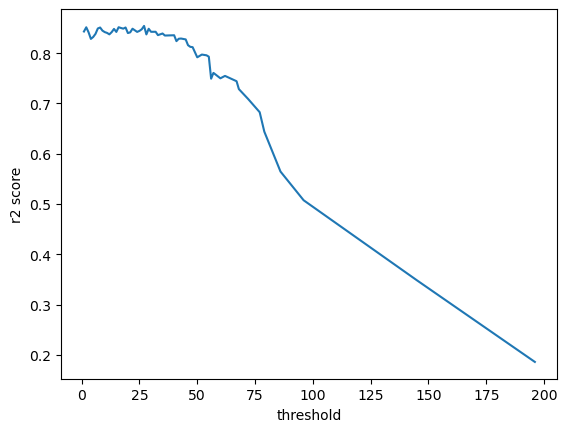

In [ ]:
#plot the results
import matplotlib.pyplot as plt
plt.plot(treshs, r2s)
plt.xlabel('threshold')
plt.ylabel('r2 score')
plt.show()

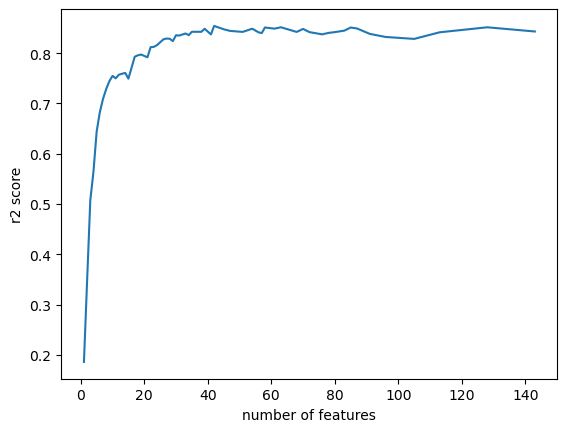

best r2 score is 0.8540498248072598 with 42 features


In [ ]:
#now plot r2 score against number of features
plt.plot(ns, r2s)
plt.xlabel('number of features')
plt.ylabel('r2 score')
plt.show()
#and give the number of features where r2 score is highest
print('best r2 score is', max(r2s), 'with', ns[r2s.index(max(r2s))], 'features')


In [ ]:
#now get these features
top_2d_features = [i for i in feature_importance_dict.keys() if feature_importance_dict[i] > treshs[r2s.index(max(r2s))]]
len(top_2d_features)
top_2d_features

['MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'BCUT2D_CHGHI',
 'MinPartialCharge',
 'MaxPartialCharge',
 'MinEStateIndex',
 'FpDensityMorgan1',
 'BCUT2D_MRLOW',
 'BCUT2D_MWLOW',
 'BalabanJ',
 'BCUT2D_MWHI',
 'BCUT2D_LOGPHI',
 'Kappa3',
 'BCUT2D_LOGPLOW',
 'MolWt',
 'BCUT2D_CHGLO',
 'PEOE_VSA6',
 'FpDensityMorgan3',
 'FpDensityMorgan2',
 'PEOE_VSA7',
 'VSA_EState3',
 'PEOE_VSA8',
 'BertzCT',
 'MinAbsPartialCharge',
 'BCUT2D_MRHI',
 'VSA_EState8',
 'AvgIpc',
 'EState_VSA3',
 'TPSA',
 'VSA_EState7',
 'EState_VSA6',
 'VSA_EState4',
 'VSA_EState5',
 'Chi3v',
 'PEOE_VSA9',
 'EState_VSA5',
 'MolLogP',
 'Kappa2',
 'Chi2n',
 'SMR_VSA5',
 'MaxAbsPartialCharge']

In [ ]:
print(top_2d_features)

['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge', 'MinEStateIndex', 'FpDensityMorgan1', 'BCUT2D_MRLOW', 'BCUT2D_MWLOW', 'BalabanJ', 'BCUT2D_MWHI', 'BCUT2D_LOGPHI', 'Kappa3', 'BCUT2D_LOGPLOW', 'MolWt', 'BCUT2D_CHGLO', 'PEOE_VSA6', 'FpDensityMorgan3', 'FpDensityMorgan2', 'PEOE_VSA7', 'VSA_EState3', 'PEOE_VSA8', 'BertzCT', 'MinAbsPartialCharge', 'BCUT2D_MRHI', 'VSA_EState8', 'AvgIpc', 'EState_VSA3', 'TPSA', 'VSA_EState7', 'EState_VSA6', 'VSA_EState4', 'VSA_EState5', 'Chi3v', 'PEOE_VSA9', 'EState_VSA5', 'MolLogP', 'Kappa2', 'Chi2n', 'SMR_VSA5', 'MaxAbsPartialCharge']


In [ ]:
#now get the new dataframe with only these features
X = df[new_features]
y = df.iloc[:, -1]
#make numpy array
X = X.to_numpy()
#print shape
X.shape


(3019, 143)

In [ ]:
import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
output = [[], []]
kf = KFold(n_splits=5)
for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp = model.predict(dtest)


    output[0].append(test_y)
    output[1].append(pp)

5it [00:00,  5.80it/s]


In [ ]:
#gets r2, mae and rmse
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from functools import reduce
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
print('RMSE:', mean_squared_error(real, prediction, squared=False))
print('MAE:', mean_absolute_error(real, prediction))
print('R2:', r2_score(real, prediction))

RMSE: 1.2529867087000601
MAE: 0.7713949747983927
R2: 0.8797122798945133


In [ ]:
#plot the results
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress
import matplotlib.pyplot as plt


def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue

def density_plot(real,prediction,print_stats=True,bounds=None,title=None):
    slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(real, prediction)
    if print_stats:
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)
    fsize = 20
    fig = plt.figure(1, figsize=(10, 6.15))
    ax = plt.subplot(111)
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    x = np.linspace(lower, upper,100)
    y = slope_mdfp_d*x+intercept_mdfp_d
    plt.plot(x, y, '-r')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

    import statsmodels.api as sm
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction],var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])

    sc = plt.scatter(real, prediction, lw=0, c=z, s=10, alpha = 0.9)

    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=fsize)


    plt.xlabel(r'Exp. VP (log10 kPa)', fontsize=fsize)
    plt.ylabel(r'Predicted VP (log10 kPa)', fontsize=fsize)
    plt.setp(ax.get_xticklabels(), fontsize=fsize)
    plt.setp(ax.get_yticklabels(), fontsize=fsize)
    plt.grid(1,"both")
    plt.axis([lower, upper, lower, upper])
    plt.text(0.05, 0.95, f'RMSE: {this_rmse:.2f}\nMAE: {this_mae:.2f}\nR2: {r2:.2f}', transform=ax.transAxes, fontsize=fsize, verticalalignment='top')
    #make square
    if title is not None:
        plt.title(title, fontsize=fsize)
    ax.set_aspect('equal', 'box')
    plt.show()


RMSE:  1.2529867087000601
MAE:  0.7713949747983927
R2:  0.879847477283201


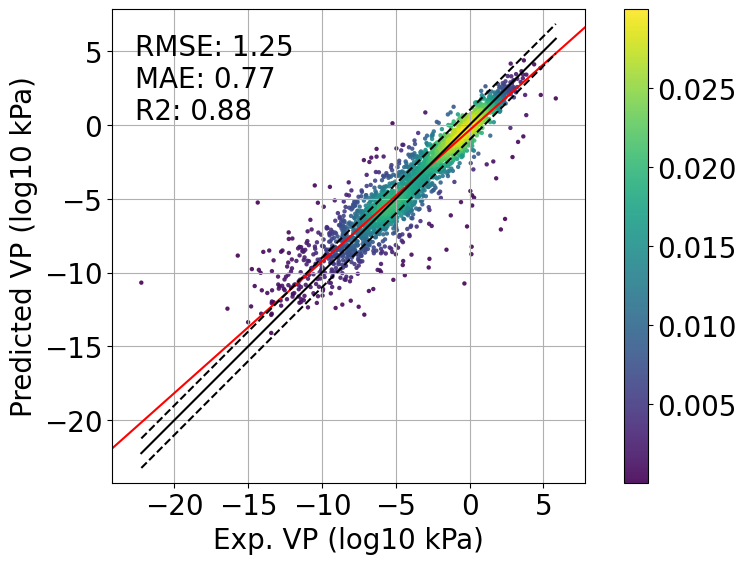

In [ ]:
density_plot(real,prediction)

Text(0, 0.5, 'metric value')

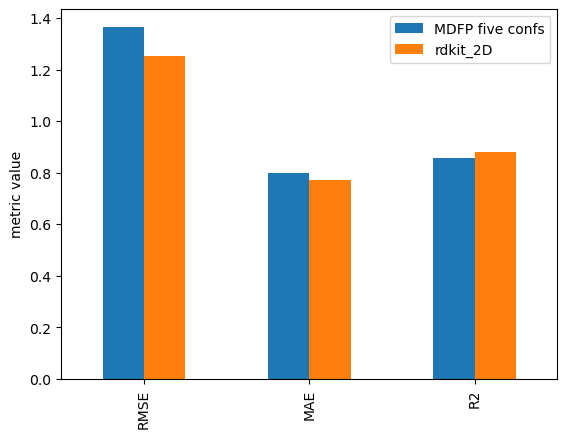

In [ ]:
df_metrics = pd.read_csv('metrics_vp_pred.csv')
df_metrics
#add new column
df_metrics['rdkit_2D'] = [mean_squared_error(real, prediction, squared=False), mean_absolute_error(real, prediction), r2_score(real, prediction)]
df_metrics
#get columns Augmentation_mean_hp_opt	rdkit_2D
#rename column Augmentation_mean_hp_opt
df_metrics = df_metrics.rename(columns={'Augmentation_mean_hp_opt': 'MDFP five confs'})

df_comparison_metrics = df_metrics[['MDFP five confs', 'rdkit_2D']]
df_comparison_metrics
#plot
df_comparison_metrics.plot.bar()
plt.xticks([0,1,2], ['RMSE', 'MAE', 'R2'])  
plt.ylabel('metric value')


In [ ]:
#how about if we combined them?

In [ ]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
SELECT cs_mdfps_schema.confid_data.conf_id AS confid,
       public.conformers.molblock,
       cs_mdfps_schema.experimental_data.vp,
       cs_mdfps_schema.mdfp_experiment_data.mdfp
FROM cs_mdfps_schema.confid_data
INNER JOIN public.conformers
ON cs_mdfps_schema.confid_data.conf_id = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.experimental_data
ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
INNER JOIN cs_mdfps_schema.mdfp_experiment_data
ON cs_mdfps_schema.confid_data.conf_id = cs_mdfps_schema.mdfp_experiment_data.conf_id
WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835';
'''
# Execute the SQL query
cur.execute(sql_query)
results = cur.fetchall()
#print columns with index
print('Columns:')
for col in cur.description:
    print(col)
mdfps = [json.loads(r[3]['mdfp']) for r in results]
vps = [r[2] for r in results]
molblokcs = [r[1] for r in results]
mols = [Chem.MolFromMolBlock(m) for m in molblokcs]
MolDescriptors_vectors_ = [list(CalcMolDescriptors(m).values()) for m in mols]



Columns:
Column(name='confid', type_code=23)
Column(name='molblock', type_code=25)
Column(name='vp', type_code=701)
Column(name='mdfp', type_code=3802)


[13:41:51] Warning: molecule is tagged as 3D, but all Z coords are zero


In [ ]:
confids = [r[0] for r in results]

In [ ]:
#make one big dataframe, where each item of the mdfp is a column and each item  of the rdkit descriptors is a column
df_rdkit = pd.DataFrame(MolDescriptors_vectors, columns = list(CalcMolDescriptors(mols[0]).keys()))
df_rdkit['confid'] = confids



In [ ]:
#disect the mdfps
example = {'2d_counts': [6, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'water_intra_crf': [8.447469879840682, 0.07754269775241597, 8.448101852311458], 'water_intra_lj': [14.698494638650427, 0.35388130931658185, 14.62080608686442], 'water_total_crf': [-20.59946506906263, 8.513642293598433, -18.724968586184893], 'water_total_lj': [-20.978276995376827, 4.06594223290863, -22.954899317973993], 'water_intra_ene': [23.14596451849111, 0.3528157869181612, 23.10431903412804], 'water_total_ene': [-41.57774206443945, 6.698043493291234, -39.76306852550783], 'water_rgyr': [1.4897907974950872, 0.0031876909007386768, 1.4891081418027634], 'water_sasa': [2.433884, 0.007920546, 2.4333215]}
mdfp_keys = list(example.keys())
mdfp_keys_full =[]
features_2d = ['NumHeavyAtoms','NumRotatableBonds','NumN','NumO','NumF','NumP','NumS','NumCl','NumBr','NumI']
for key in mdfp_keys:
    if key != '2d_counts':
        for i in ['mean', 'std', 'median']:
            mdfp_keys_full.append(f'{key}_{i}')
    else:
        mdfp_keys_full.extend(features_2d)
print(mdfp_keys_full,len(mdfp_keys_full))
#now make a df from data that we have
column_names = [col[0] for col in cur.description]
df = pd.DataFrame(results, columns=column_names)
#add the mdfp keys
for i,key in enumerate(mdfp_keys_full):
    df[key] = [mdfps[j][i] for j in range(len(mdfps))]
df

['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median'] 34


,confid,molblock,vp,mdfp,NumHeavyAtoms,NumRotatableBonds,NumN,NumO,NumF,NumP,...,water_intra_ene_median,water_total_ene_mean,water_total_ene_std,water_total_ene_median,water_rgyr_mean,water_rgyr_std,water_rgyr_median,water_sasa_mean,water_sasa_std,water_sasa_median
0,2388,[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H...,-0.674795,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24....",10,1,0,0,0,0,...,5.081368,-72.161483,10.529911,-72.402603,0.239207,0.001838,0.239275,3.536894,0.017106,3.536101
1,2394,[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...,-0.907920,"{'mdfp': '[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.74...",7,4,0,1,0,0,...,4.578916,-99.110528,13.121092,-99.618129,0.234266,0.012069,0.233745,3.125541,0.054318,3.125999
2,2400,[H]c1c([H])c([H])c(N([H])C([H])([H])C#N)c([H])...,-3.000000,"{'mdfp': '[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13....",10,2,2,0,0,0,...,10.904916,-127.549064,15.489246,-127.568218,0.258037,0.011765,0.264010,3.292758,0.020541,3.296084
3,2406,[H]N(C(=O)/C(C#N)=N/OC([H])([H])[H])C(=O)N([H]...,-6.822020,"{'mdfp': '[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411...",14,3,4,3,0,0,...,-388.562189,-648.902490,21.619238,-648.956024,0.332311,0.004967,0.332628,4.316147,0.032678,4.317026
4,2411,[H]c1c([H])c([H])c(Oc2c([H])c([H])c(Br)c([H])c...,-4.772345,"{'mdfp': '[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36....",15,2,0,1,0,0,...,12.365653,-111.465809,13.073721,-112.106635,0.377372,0.009262,0.378641,4.357666,0.036732,4.363505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,4239,[H]c1c(Cl)c([H])c2c(oc3c(Cl)c(Cl)c([H])c([H])c...,-8.356584,"{'mdfp': '[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.03...",17,0,0,1,0,0,...,35.942550,-87.784837,10.140912,-89.362709,0.360165,0.001351,0.360199,4.410722,0.013328,4.410184
3015,4240,[H]c1c([H])c(Oc2c([H])c(Cl)c(Cl)c(Cl)c2Cl)c(Cl...,-6.770000,"{'mdfp': '[19, 2, 0, 1, 0, 0, 0, 6, 0, 0, -30....",19,2,0,1,0,0,...,19.204756,-114.932311,11.920257,-115.549134,0.384894,0.005319,0.385510,4.996278,0.047191,5.006945
3016,4242,[H]C([H])([H])C(=O)C1=C(C([H])([H])[H])[C@]2([...,2.397940,"{'mdfp': '[18, 1, 0, 1, 0, 0, 0, 0, 0, 0, -99....",18,1,0,1,0,0,...,-35.676070,-189.774735,17.915495,-190.148519,0.285020,0.001422,0.285051,4.630872,0.029091,4.630780
3017,4243,[H]OC([H])([H])[C@@]([H])(O[H])[C@]([H])(O[H])...,-10.580632,"{'mdfp': '[10, 4, 0, 5, 0, 0, 0, 0, 0, 0, 213....",10,4,0,5,0,0,...,228.514719,-28.576307,26.008900,-28.331167,0.237946,0.005679,0.238746,3.190095,0.033937,3.189645


In [ ]:
#now merge the two on confid
df_merged = pd.merge(df_rdkit, df, on='confid')
#move column 'vp' to index 0
df_merged = df_merged.set_index('vp').reset_index()
df_merged
#drop numrotatablebonds_x
df_merged = df_merged.drop(columns=['NumRotatableBonds_x'])
#rename numrotatablebonds_y to numrotatablebonds
df_merged = df_merged.rename(columns={'NumRotatableBonds_y': 'NumRotatableBonds'})

In [ ]:
X = df_merged.iloc[:, 1:]
y = df_merged.iloc[:, 0]
#drop molblock
X = X.drop(['molblock'], axis=1)
#drop mdfp
X = X.drop(['mdfp'], axis=1)


In [ ]:
# use feature importance for feature selection, with fix for xgboost 1.0.2
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
X = df_merged.iloc[:, 1:]
y = df_merged.iloc[:, 0]
X = X.drop(['molblock'], axis=1)
#drop mdfp
X = X.drop(['mdfp'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = r2_score(y_test, predictions)
print("r2_score: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = model.get_booster().get_score(importance_type='weight')

feature_importance_dict = {k: v for k, v in sorted(thresholds.items(), key=lambda item: item[1], reverse=True)}


r2_score: 85.33%


In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score
treshs,ns,r2s = [],[],[]
tresholds = feature_importance_dict.values()
tresholds = list(set(tresholds))
#sort: highest first
tresholds.sort(reverse=True)
for thresh in tresholds:
    # Get features from feature_importance_dict with a value above the threshold
    new_features = [i for i in feature_importance_dict.keys() if feature_importance_dict[i] > thresh]

    # Check if there are selected features
    if len(new_features) == 0:
        print("No features selected for threshold %.3f" % thresh)
        continue

    # Now get DataFrames X with only the new features
    X_train_new = X_train[new_features]
    X_test_new = X_test[new_features]

    selection_model = xgb.XGBRegressor()
    selection_model.fit(X_train_new, y_train)
    
    # Evaluate the model
    predictions = selection_model.predict(X_test_new)
    accuracy = r2_score(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, r2_score: %.2f%%" % (thresh, X_train_new.shape[1], accuracy))
    treshs.append(thresh)
    ns.append(X_train_new.shape[1])
    r2s.append(accuracy)



No features selected for threshold 379.000
Thresh=184.000, n=1, r2_score: 0.19%
Thresh=126.000, n=2, r2_score: 0.35%
Thresh=109.000, n=3, r2_score: 0.51%
Thresh=79.000, n=4, r2_score: 0.46%
Thresh=73.000, n=5, r2_score: 0.53%
Thresh=65.000, n=6, r2_score: 0.65%
Thresh=60.000, n=7, r2_score: 0.69%
Thresh=55.000, n=8, r2_score: 0.75%
Thresh=53.000, n=9, r2_score: 0.80%
Thresh=52.000, n=11, r2_score: 0.81%
Thresh=51.000, n=13, r2_score: 0.81%
Thresh=50.000, n=14, r2_score: 0.81%
Thresh=49.000, n=17, r2_score: 0.83%
Thresh=47.000, n=18, r2_score: 0.83%
Thresh=46.000, n=20, r2_score: 0.83%
Thresh=45.000, n=21, r2_score: 0.83%
Thresh=42.000, n=22, r2_score: 0.81%
Thresh=41.000, n=24, r2_score: 0.82%
Thresh=39.000, n=25, r2_score: 0.82%
Thresh=37.000, n=27, r2_score: 0.84%
Thresh=36.000, n=34, r2_score: 0.83%
Thresh=35.000, n=35, r2_score: 0.83%
Thresh=34.000, n=37, r2_score: 0.84%
Thresh=33.000, n=39, r2_score: 0.84%
Thresh=32.000, n=43, r2_score: 0.85%
Thresh=31.000, n=45, r2_score: 0.85%
T

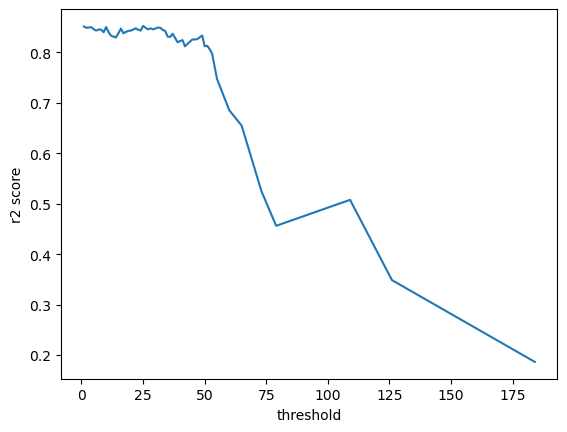

In [ ]:
#plot
import matplotlib.pyplot as plt
plt.plot(treshs, r2s)
plt.xlabel('threshold')
plt.ylabel('r2 score')
plt.show()


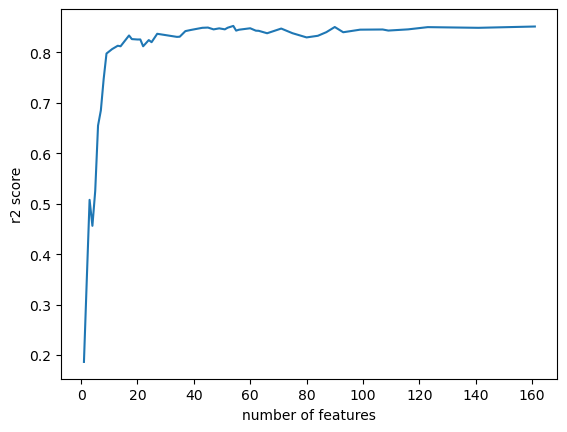

best r2 score is 0.8523428185627036 with 54 features


In [ ]:
#plot number of features against r2 score
plt.plot(ns, r2s)
plt.xlabel('number of features')
plt.ylabel('r2 score')
plt.show()
#and give the number of features where r2 score is highest
print('best r2 score is', max(r2s), 'with', ns[r2s.index(max(r2s))], 'features')


In [ ]:
for i in feature_importance_dict.keys():
    if feature_importance_dict[i] > 40:
        print(i, feature_importance_dict[i])


MaxAbsEStateIndex 379.0
MinAbsEStateIndex 184.0
qed 126.0
confid 109.0
MinEStateIndex 79.0
MinPartialCharge 73.0
MaxPartialCharge 65.0
MolWt 60.0
BCUT2D_MWHI 55.0
water_total_crf_std 53.0
water_total_lj_std 53.0
BCUT2D_LOGPLOW 52.0
water_rgyr_std 52.0
water_sasa_std 51.0
BCUT2D_MWLOW 50.0
BCUT2D_LOGPHI 50.0
water_total_lj_mean 50.0
BCUT2D_CHGHI 49.0
FpDensityMorgan1 47.0
BCUT2D_MRLOW 47.0
water_total_ene_std 46.0
BalabanJ 45.0
BCUT2D_CHGLO 42.0
BCUT2D_MRHI 42.0
water_intra_crf_mean 41.0


In [ ]:
#get these features
new_features = [i for i in feature_importance_dict.keys() if feature_importance_dict[i] > treshs[r2s.index(max(r2s))]]
len(new_features)
new_features

['MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'confid',
 'MinEStateIndex',
 'MinPartialCharge',
 'MaxPartialCharge',
 'MolWt',
 'BCUT2D_MWHI',
 'water_total_crf_std',
 'water_total_lj_std',
 'BCUT2D_LOGPLOW',
 'water_rgyr_std',
 'water_sasa_std',
 'BCUT2D_MWLOW',
 'BCUT2D_LOGPHI',
 'water_total_lj_mean',
 'BCUT2D_CHGHI',
 'FpDensityMorgan1',
 'BCUT2D_MRLOW',
 'water_total_ene_std',
 'BalabanJ',
 'BCUT2D_CHGLO',
 'BCUT2D_MRHI',
 'water_intra_crf_mean',
 'FpDensityMorgan2',
 'BertzCT',
 'MinAbsPartialCharge',
 'Chi3v',
 'EState_VSA3',
 'VSA_EState3',
 'water_intra_crf_std',
 'water_intra_lj_mean',
 'water_intra_lj_std',
 'Kappa3',
 'TPSA',
 'VSA_EState8',
 'AvgIpc',
 'VSA_EState7',
 'PEOE_VSA7',
 'VSA_EState5',
 'MolLogP',
 'water_rgyr_mean',
 'PEOE_VSA6',
 'water_intra_ene_std',
 'EState_VSA4',
 'VSA_EState6',
 'FpDensityMorgan3',
 'Chi1v',
 'VSA_EState4',
 'water_intra_ene_mean',
 'SlogP_VSA2',
 'EState_VSA5',
 'water_total_ene_mean']

In [ ]:
X = df_merged[new_features]
#make numpy array
X = X.to_numpy()
#print shape
X.shape

(3019, 54)

In [ ]:
import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
output = [[], []]
kf = KFold(n_splits=5)
for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp = model.predict(dtest)


    output[0].append(test_y)
    output[1].append(pp)
    


5it [00:00,  5.99it/s]


In [ ]:
#gets r2, mae and rmse
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from functools import reduce
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
print('RMSE:', mean_squared_error(real, prediction, squared=False))
print('MAE:', mean_absolute_error(real, prediction))
print('R2:', r2_score(real, prediction))

RMSE: 1.3052299049182985
MAE: 0.8308996584253358
R2: 0.8694723868790765


In [ ]:
#add new column
df_metrics['combined'] = [mean_squared_error(real, prediction, squared=False), mean_absolute_error(real, prediction), r2_score(real, prediction)]
df_metrics

,Metric,Same Conformer,Same Mol per Conf,Different Mol,Same Mol Averaged,Augmentation,Augmentation_mean,MDFP five confs,rdkit_2D,combined
0,RMSE,0.001999,0.828613,1.386804,0.686796,1.500263,1.409616,1.364706,1.252987,1.305230
1,MAE,0.001351,0.524126,0.860514,0.429791,0.895319,0.837867,0.798393,0.771395,0.830900
2,R2,1.000000,0.947605,0.852760,0.964007,0.829594,0.848282,0.857431,0.879712,0.869472


In [ ]:
#can we predict from just Estate descriptors?


In [ ]:
import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
output = [[], []]
#only get estate descriptors: columns MaxEStateIndex	MinEStateIndex	MaxAbsEStateIndex	MinAbsEStateIndex
X = df_merged[['MaxAbsEStateIndex', 'MinAbsEStateIndex','MolWt']]
#make numpy array
X = X.to_numpy()
#print shape
X.shape
y = df_merged[['vp']]
y = y.to_numpy()

kf = KFold(n_splits=5)
for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp = model.predict(dtest)


    output[0].append(test_y)
    output[1].append(pp)
#gets r2, mae and rmse
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from functools import reduce
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
real = [r[0] for r in real]
print('RMSE:', mean_squared_error(real, prediction, squared=False))
print('MAE:', mean_absolute_error(real, prediction))
print('R2:', r2_score(real, prediction))
#using just the E-State variables and molar weight we already get a damned good prediction of the vapour pressure.

5it [00:00, 23.89it/s]

RMSE: 2.060612466964146
MAE: 1.4483603064699566
R2: 0.6746723236573346


RMSE:  2.060612466964146
MAE:  1.4483603064699566
R2:  0.6746911932012191


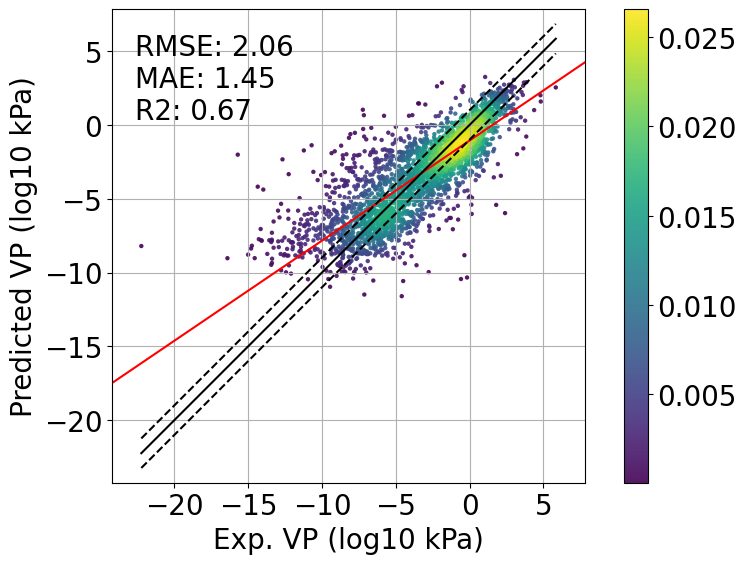

In [ ]:
density_plot(real,prediction)

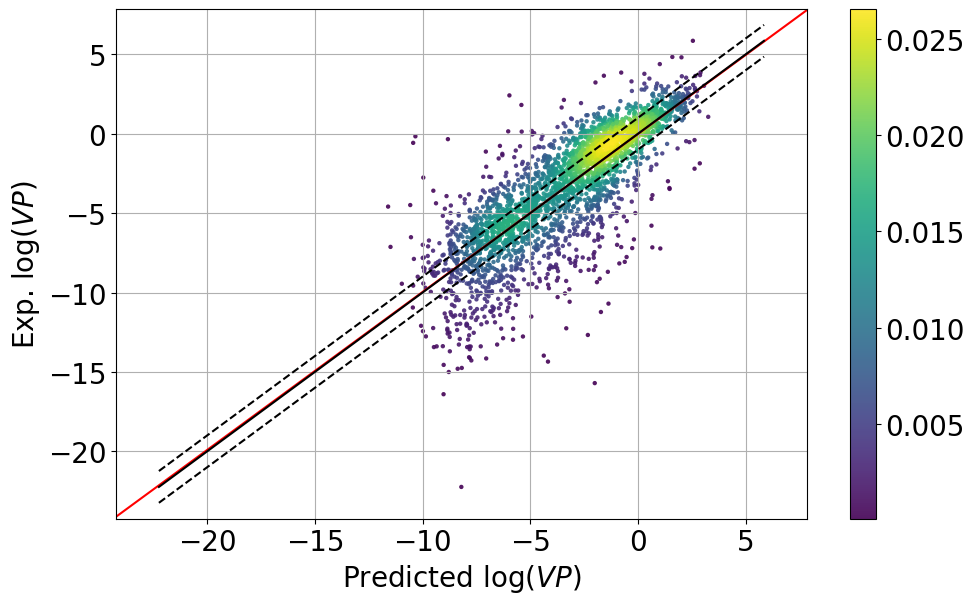

In [ ]:
fsize = 20
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = min(prediction + real) - 2
upper = max(prediction + real) + 2
x = np.linspace(lower, upper,100)
slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
y = slope_mdfp_d*x+intercept_mdfp_d
plt.plot(x, y, '-r')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[prediction, real],var_type='cc', bw='normal_reference')
z = dens_u.pdf([prediction, real])

sc = plt.scatter(prediction, real, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=fsize)
plt.setp(ax.get_yticklabels(), fontsize=fsize)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
plt.tight_layout()
plt.show()
#this is using three descriptors...

In [ ]:
df.head()
import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
output = ([],[],[],[])
#only get important_2d_features
X_2d = df_merged[top_2d_features]
#make numpy array
X_2d = X_2d.to_numpy()
#print shape
y = df_merged[['vp']]
y = y.to_numpy()
confids = df_merged[['confid']]
confids = confids.to_numpy()
X_mdfp = df_merged[mdfp_keys_full]
X_mdfp = X_mdfp.to_numpy()

kf = KFold(n_splits=5)
for train, test in tqdm.tqdm(kf.split(X)):
    train_x_2d = np.array(X_2d)[train]
    train_y = np.array(y)[train]
    test_x_2d = np.array(X_2d)[test]
    test_y = np.array(y)[test]
    train_x_mdfp = np.array(X_mdfp)[train]
    test_x_mdfp = np.array(X_mdfp)[test]

    dtrain_2d = xgb.DMatrix(train_x_2d, label=train_y)
    dtrain_mdfp = xgb.DMatrix(train_x_mdfp, label=train_y)
    dtest_2d = xgb.DMatrix(test_x_2d, label=test_y)
    dtest_mdfp = xgb.DMatrix(test_x_mdfp, label=test_y)

    test_confids = np.array(confids)[test]

    
    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp_2d = model_2d.predict(dtest_2d)

    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp_mdfp = model_mdfp.predict(dtest_mdfp)


    output[0].append(test_y)
    output[1].append(pp_2d)
    output[2].append(test_confids)
    output[3].append(pp_mdfp)

5it [00:00,  8.05it/s]


In [ ]:
for train, test in tqdm.tqdm(kf.split(X_2d)):  # Change X to X_2d
    train_x_2d = np.array(X_2d)[train]
    train_y = np.array(y)[train]
    test_x_2d = np.array(X_2d)[test]
    test_y = np.array(y)[test]
    train_x_mdfp = np.array(X_mdfp)[train]
    test_x_mdfp = np.array(X_mdfp)[test]

    dtrain_2d = xgb.DMatrix(train_x_2d, label=train_y)
    dtrain_mdfp = xgb.DMatrix(train_x_mdfp, label=train_y)
    dtest_2d = xgb.DMatrix(test_x_2d, label=test_y)
    dtest_mdfp = xgb.DMatrix(test_x_mdfp, label=test_y)

    test_confids = np.array(confids)[test]

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],  # Change dtest to dtest_2d
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp_2d = model_2d.predict(dtest_2d)

    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],  # Change dtest to dtest_mdfp
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp_mdfp = model_mdfp.predict(dtest_mdfp)

    output[0].append(test_y)
    output[1].append(pp_2d)
    output[2].append(test_confids)
    output[3].append(pp_mdfp)


5it [00:01,  3.79it/s]


In [ ]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
confids = reduce(lambda a,b : list(a)+list(b), output[2])
pred_mdfp = reduce(lambda a,b : list(a)+list(b), output[3])
confids = [c[0] for c in confids]
vps = [v[0] for v in vps]
df_2d = pd.DataFrame({'vp': vps, 'pred_2d': preds, 'confid': confids, 'pred_mdfp': pred_mdfp})
df_2d['abs_error_2d'] = abs(df_2d['vp'] - df_2d['pred_2d'])
df_2d['abs_error_mdfp'] = abs(df_2d['vp'] - df_2d['pred_mdfp'])
df_2d

,vp,pred_2d,confid,pred_mdfp,abs_error_2d,abs_error_mdfp
0,-0.674795,-0.788582,2388,-1.093748,0.113787,0.418953
1,-0.907920,-0.625550,2394,-0.061378,0.282370,0.846541
2,-3.000000,-3.224132,2400,-2.511356,0.224132,0.488644
3,-6.822020,-6.413310,2406,-7.259660,0.408710,0.437641
4,-4.772345,-5.217643,2411,-4.516304,0.445297,0.256041
...,...,...,...,...,...,...
6033,-8.356584,-8.085749,4239,-7.290298,0.270836,1.066286
6034,-6.770000,-6.445831,4240,-6.099500,0.324169,0.670500
6035,2.397940,-6.000969,4242,-5.000634,8.398909,7.398574
6036,-10.580632,-8.269021,4243,-5.398918,2.311611,5.181714


In [ ]:
#get mean of abs error
print(df_2d['abs_error_2d'].mean(),len(df_2d['abs_error_2d']))
print(df_2d['abs_error_mdfp'].mean(),len(df_2d['abs_error_mdfp']))

print(df_2d[df_2d['abs_error_2d'] < 5]['abs_error_2d'].mean(),len(df_2d[df_2d['abs_error_2d'] < 5]['abs_error_2d']))
print(df_2d[df_2d['abs_error_mdfp'] < 5]['abs_error_mdfp'].mean(),len(df_2d[df_2d['abs_error_mdfp'] < 5]['abs_error_mdfp']))

print(df_2d[df_2d['abs_error_2d'] < 1]['abs_error_2d'].mean(),len(df_2d[df_2d['abs_error_2d'] < 1]['abs_error_2d']))
print(df_2d[df_2d['abs_error_mdfp'] < 1]['abs_error_mdfp'].mean(),len(df_2d[df_2d['abs_error_mdfp'] < 1]['abs_error_mdfp']))

0.8711789873093978 6038
0.9251799013478181 6038
0.8250733977099522 5992
0.84745891901529 5958
0.3916796137368553 4308
0.39949918864840167 4244


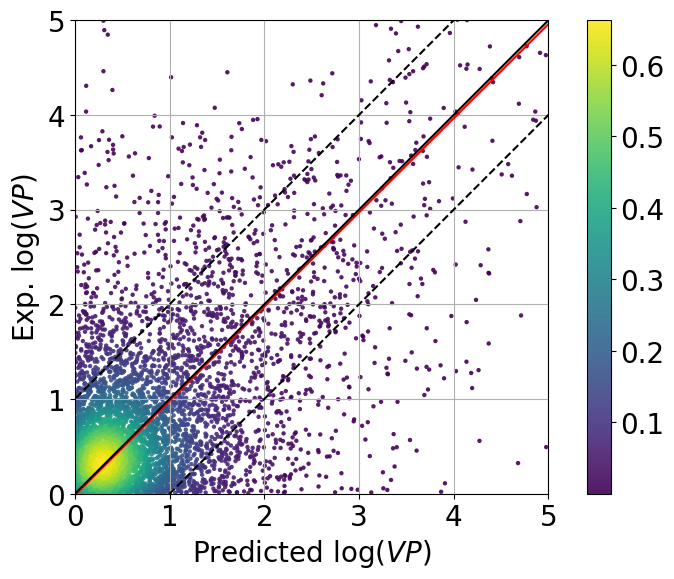

In [ ]:
fsize = 20
prediction = df_2d['abs_error_2d'] 
real = df_2d['abs_error_mdfp']
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = 0
upper = 5
x = np.linspace(lower, upper,100)
y = slope_mdfp_d*x+intercept_mdfp_d
plt.plot(x, y, '-r')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[prediction, real],var_type='cc', bw='normal_reference')
z = dens_u.pdf([prediction, real])

sc = plt.scatter(prediction, real, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=fsize)
plt.setp(ax.get_yticklabels(), fontsize=fsize)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
#make square
ax.set_aspect('equal', 'box')
plt.show()

In [ ]:
#new column: abs error 2d - abs error mdfp
df_2d['abs_error_diff'] = df_2d['abs_error_2d'] - df_2d['abs_error_mdfp']
#sort by abs error diff
df_2d.sort_values(by=['abs_error_diff'])
#get top 50 confids
top_50_confids = df_2d.sort_values(by=['abs_error_diff']).head(50)['confid'].tolist()
top_50_confids


[2341,
 1226,
 2341,
 2708,
 3044,
 3044,
 3286,
 3755,
 4202,
 2708,
 2168,
 2168,
 1753,
 4196,
 2820,
 3969,
 2998,
 1226,
 4031,
 2998,
 3098,
 2034,
 2986,
 4196,
 3510,
 1294,
 2820,
 2372,
 3969,
 1294,
 2730,
 1661,
 3510,
 3834,
 3834,
 1417,
 2516,
 2584,
 1919,
 2372,
 3546,
 3098,
 2045,
 4202,
 2012,
 3546,
 2331,
 3565,
 1417,
 2561]

In [ ]:
column_names = df_merged.columns
'NumRotatableBonds' in column_names

True

In [ ]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
confids = reduce(lambda a,b : list(a)+list(b), output[2])
confids = [c[0] for c in confids]
vps = [v[0] for v in vps]
df_2d = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids})
df_2d['abs_error'] = abs(df_2d['vp'] - df_2d['pred'])
df_2d

,vp,pred,confid,abs_error
0,-0.674795,-0.788582,2388,0.113787
1,-0.907920,-0.625550,2394,0.282370
2,-3.000000,-3.224132,2400,0.224132
3,-6.822020,-6.413310,2406,0.408710
4,-4.772345,-5.217643,2411,0.445297
...,...,...,...,...
6033,-8.356584,-8.085749,4239,0.270836
6034,-6.770000,-6.445831,4240,0.324169
6035,2.397940,-6.000969,4242,8.398909
6036,-10.580632,-8.269021,4243,2.311611


In [ ]:
mdfp_keys_full

['NumHeavyAtoms',
 'NumRotatableBonds',
 'NumN',
 'NumO',
 'NumF',
 'NumP',
 'NumS',
 'NumCl',
 'NumBr',
 'NumI',
 'water_intra_crf_mean',
 'water_intra_crf_std',
 'water_intra_crf_median',
 'water_intra_lj_mean',
 'water_intra_lj_std',
 'water_intra_lj_median',
 'water_total_crf_mean',
 'water_total_crf_std',
 'water_total_crf_median',
 'water_total_lj_mean',
 'water_total_lj_std',
 'water_total_lj_median',
 'water_intra_ene_mean',
 'water_intra_ene_std',
 'water_intra_ene_median',
 'water_total_ene_mean',
 'water_total_ene_std',
 'water_total_ene_median',
 'water_rgyr_mean',
 'water_rgyr_std',
 'water_rgyr_median',
 'water_sasa_mean',
 'water_sasa_std',
 'water_sasa_median']

In [ ]:
#look at the mols for top_50_confids
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute('select molblock from public.conformers where conf_id in %s', (tuple(top_50_confids),))
molblocks = cur.fetchall()
mols = [Chem.MolFromMolBlock(m[0]) for m in molblocks]
mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]  
# Draw.MolsToGridImage(mols, molsPerRow=1, subImgSize=(600, 600), legends=[str(i) for i in range(len(mols))])

In [ ]:
#look at estate descriptors
test_mol = Chem.AddHs(Chem.MolFromSmiles('CC(C)C1=CC=C(C=C1)C(=O)O'))
test_mol
from rdkit.Chem.EState import EState

EStateIndices = EState.EStateIndices(test_mol)
MaxAbsEStateIndex = EState.MaxAbsEStateIndex(test_mol)
MaxEStateIndex = EState.MaxEStateIndex(test_mol)
MinAbsEStateIndex = EState.MinAbsEStateIndex(test_mol)
MinEStateIndex = EState.MinEStateIndex(test_mol)
#PRINT ALL OUT
print(f'EStateIndices: {EStateIndices}')
print(f'MaxAbsEStateIndex: {MaxAbsEStateIndex}')
print(f'MaxEStateIndex: {MaxEStateIndex}')
print(f'MinAbsEStateIndex: {MinAbsEStateIndex}')
print(f'MinEStateIndex: {MinEStateIndex}')


EStateIndices: [-3.51371173 -3.45519239 -3.51371173 -1.18145314 -1.16791667 -1.08946759
 -0.95631141 -1.08946759 -1.16791667 -1.53065004 11.42883999  3.60325633
  7.36266456  7.36266456  7.36266456  7.97734434  7.36266456  7.36266456
  7.36266456  7.77789352  7.67074074  7.67074074  7.77789352  6.49976911]
MaxAbsEStateIndex: 11.428839994331065
MaxEStateIndex: 11.428839994331065
MinAbsEStateIndex: 0.9563114134542705
MinEStateIndex: -3.513711734693879


In [ ]:
from rdkit.Chem import Descriptors
from rdkit import Chem
test_mol = Chem.AddHs(Chem.MolFromSmiles('CC(C)C1=CC=C(C=C1)C(=O)O'))

In [18]:
%timeit [Descriptors.CalcMolDescriptors(test_mol) for test_mol in mols]

17.5 s ± 612 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
117.5/len(mols)

0.03892017224246439

In [ ]:
#calc 2D descriptors: 40 ms. Calc MDFP: 300000 ms. 4 orders of magnitude slower.